# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
# выведем необходимые библиотеки для работы
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
# выводим информацию о данных трёх датафреймов 
df1 = pd.read_csv('/datasets/geo_data_0.csv')
df2 = pd.read_csv('/datasets/geo_data_1.csv')
df3 = pd.read_csv('/datasets/geo_data_2.csv')

def info(df): 
    display(df.head(3))
    df.info()
    print()
    
for i in [df1, df2, df3]:
    info(i)


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB



,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB



,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB



In [3]:
# проверяем дубликаты в столбце 'id'
def duplicate(df):
    print(df['id'].duplicated().sum())
for i in [df1, df2, df3]:
    duplicate(i)   
    

10
4
4


In [4]:
# удаляем строки с дубликатами из столбца 'id'
def drop(df):
    df = df['id'].drop_duplicates().reset_index(drop=True)
for i in [df1, df2, df3]:
    drop(i)   

In [5]:
# для удобства сделаем список датафреймов
data_all = [ df1.drop('id', axis=1), df2.drop('id', axis=1), df3.drop('id', axis=1)]

In [6]:
# проверяем наличие пропусков в данных
[display(data_all.isna().sum()) for data_all in [df1, df2, df3]]

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

[None, None, None]

In [7]:
# проверяем данные на наличие дубликатов
[display(data_all.duplicated().sum()) for data_all in [df1, df2, df3]]


0

0

0

[None, None, None]

In [8]:
# выведем матрицу корреляций коэффициента Пирсона
[display(data_all.corr().round(3).head()) for data_all in [df1, df2, df3]]
       

,f0,f1,f2,product
f0,1.000,-0.441,-0.003,0.144
f1,-0.441,1.000,0.002,-0.192
f2,-0.003,0.002,1.000,0.484
product,0.144,-0.192,0.484,1.000


,f0,f1,f2,product
f0,1.000,0.182,-0.002,-0.030
f1,0.182,1.000,-0.003,-0.010
f2,-0.002,-0.003,1.000,0.999
product,-0.030,-0.010,0.999,1.000


,f0,f1,f2,product
f0,1.000,0.001,-0.000,-0.002
f1,0.001,1.000,0.001,-0.001
f2,-0.000,0.001,1.000,0.446
product,-0.002,-0.001,0.446,1.000


[None, None, None]

array([[<AxesSubplot:title={'center':'f0'}>,
        <AxesSubplot:title={'center':'f1'}>],
       [<AxesSubplot:title={'center':'f2'}>, <AxesSubplot:>]],
      dtype=object)

array([[<AxesSubplot:title={'center':'f0'}>,
        <AxesSubplot:title={'center':'f1'}>],
       [<AxesSubplot:title={'center':'f2'}>, <AxesSubplot:>]],
      dtype=object)

array([[<AxesSubplot:title={'center':'f0'}>,
        <AxesSubplot:title={'center':'f1'}>],
       [<AxesSubplot:title={'center':'f2'}>, <AxesSubplot:>]],
      dtype=object)

[None, None, None]

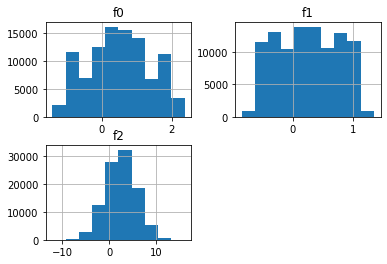

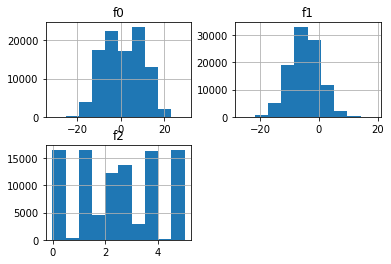

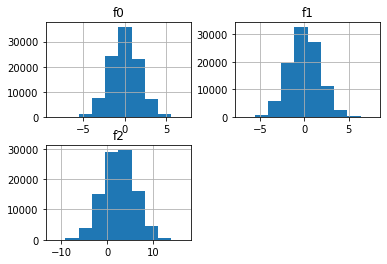

In [9]:
# выведем рааспределение признаков
[display(data_all[["f0","f1","f2"]].hist()) for data_all in [df1, df2, df3]]


### Вывод

Данные изучены. В детафреймах нет пропусков, немногочисленные дубликаты были удалены. Выявлена корреляция данных. Данные распределены близко к нормальному распределению и готовы к обученению и проверке модели.   

## Обучение и проверка модели

In [10]:
# создаём функцию, принимающая на вход датафрейм
def split_and_train(df):
    
# извлекаем целевой признак
    target = df["product"]
    
# извлекаем признаки
    features = df.drop(["product","id"], axis=1)

# выделяем 75% данных для обучающей выборки, остальные данные для валидационной
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size = 0.25, random_state = 12345)
    
# создадим объект структуры и настроим его на обучающих данных
    scaler = MinMaxScaler()
    features_train = scaler.fit_transform(features_train)
    features_valid = scaler.transform(features_valid)

# инициализируем модель LinearRegression  
    model = LinearRegression() 
    model.fit(features_train, target_train) 
    predictions = model.predict(features_valid)
    predictions = pd.Series(predictions)

# посчитаем значение метрики RMSE
    rmse = (mean_squared_error(target_valid, predictions)) ** 0.5
    
# посчитаем средний запас предсказанного сырья  
    average_product = sum(predictions) / len(predictions)
    
    display("RMSE: {0:.1f}".format(rmse)) 
    display("Средний обьём сырья: {0:.1f} тыс. баррелей".format(average_product))
    
    return (target_valid.reset_index(drop=True), predictions, rmse)


In [11]:
# через цикл прогоним каждый датафрейм
i = 1
for region in [df1, df2, df3]:
    print(f"Регион {i}:")
    split_and_train(region)
    print()
    i+=1

Регион 1:


'RMSE: 37.6'

'Средний обьём сырья: 92.6 тыс. баррелей'


Регион 2:


'RMSE: 0.9'

'Средний обьём сырья: 68.7 тыс. баррелей'


Регион 3:


'RMSE: 40.0'

'Средний обьём сырья: 95.0 тыс. баррелей'

In [12]:
# cохраним предсказания, правильные ответы и RMSE на валидационной выборке
target_valid_1, predictions_1, rmse_1 = split_and_train(df1)
target_valid_2, predictions_2, rmse_2 = split_and_train(df2)
target_valid_3, predictions_3, rmse_3 = split_and_train(df3)

'RMSE: 37.6'

'Средний обьём сырья: 92.6 тыс. баррелей'

'RMSE: 0.9'

'Средний обьём сырья: 68.7 тыс. баррелей'

'RMSE: 40.0'

'Средний обьём сырья: 95.0 тыс. баррелей'

### Вывод

Лучший показатель RMSE = 0.89 у 2 региона, получается данная модель может лучше "соответствовать" набору даннных, при этом показатель среднего запаса сырья скважины меньше.  В остальных регионах RMSE в разы больше, что хуже, но больше значение среднего запаса сырья. Произведём расчёт прибыли и рисков.

## Подготовка к расчёту прибыли

При разведке региона исследуюем 500 точек, из которых с помощью машинного обучения выберем 200 лучших для разработки.
Бюджет на разработку скважин в регионе — 10 млрд рублей.
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой барреля составляет 450 тыс.
рублей.
После оценки рисков оставим лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выберем регион с наибольшей средней прибылью.

In [13]:
# доход с одного барреля 
INCOME_PER_BARREL = 450000/10**6 

# бюджет для разработки 200 скважин
BUDGET = 10000000000/10**6

# количество скважин исследования
ALL_COUNT = 500

# количество скважин после машинного обучения
COUNT = 200

# техника Bootstrap с 1000 выборок
BOOTSTRAP_NUMBER = 1000

# бюджет для разработки одной скважины
print('Бюджет на разработку одной скважины:', int(BUDGET / 200), 'млн. руб')

# рассчитаем достаточный объём сырья для безубыточной разработки новой скважины
v_profit = int(BUDGET / 200) / INCOME_PER_BARREL
print("Объём сырья для безубыточной разработки новой скважины: {0:.1f} тыс. баррелей".format(v_profit))
     

Бюджет на разработку одной скважины: 50 млн. руб
Объём сырья для безубыточной разработки новой скважины: 111.1 тыс. баррелей


### Вывод

Среднее значение объёма скважины:
- 1 регион - 92.6 тыс. баррелей,
- 2 регион - 68.7 тыс. баррелей,
- 3 регион - 95.0 тыс. баррелей.


Для безубыточной разработки новой скважины необходимо минимум 111.1 тыс. баррелей с одной скважины. Ни один регион по средней недотягивает до безубыточного значения. Для определения нужного (прибыльного) региона необходимо расчетать общую и среднюю прибыль скважин с максимальными значениями предсказаний.

## Расчёт прибыли и рисков 

In [14]:
# функция для расчёта прибыли по выбранным скважинам и предсказаниям модели
def revenue(target, predictions, COUNT):
    preds_sorted = predictions.sort_values(ascending=False)
    selected = target[preds_sorted.index][:COUNT]
    return int(INCOME_PER_BARREL * selected.sum() - BUDGET)

In [15]:
# прибыль в первых двухстах скважинах с максимальными значениями предсказаний
print('Прибыль в первом регионе :', revenue(target_valid_1, predictions_1, COUNT), 'млн. руб')
print('Прибыль во втором регионе :', revenue(target_valid_2, predictions_2, COUNT), 'млн. руб')
print('Прибыль в третьем регионе :', revenue(target_valid_3, predictions_3, COUNT), 'млн. руб')


Прибыль в первом регионе : 3320 млн. руб
Прибыль во втором регионе : 2415 млн. руб
Прибыль в третьем регионе : 2710 млн. руб


In [16]:
# создаём цикл для расчёта средней прибыли и риска
target = [target_valid_1, target_valid_2, target_valid_3]
predictions = [predictions_1, predictions_2, predictions_3]
regions = ['Первый регион', 'Второй регион', 'Третий регион']

state = np.random.RandomState(12345)

for j in range(len(target)):
    values = []
    for i in range(BOOTSTRAP_NUMBER):
        target_subsample = target[j].sample(n=ALL_COUNT, replace=True, random_state=state)
        predictions_subsample = predictions[j].loc[target_subsample.index]
        values.append(revenue(target_subsample.reset_index(drop=True),
                predictions_subsample.reset_index(drop=True), COUNT))

    values = pd.Series(values)
    lower = values.quantile(.025)
    upper = values.quantile(.975)

    mean = values.mean()
    
    loss_probability = sum(values < 0) / values.count()* 100
    
    
    print('Вывод:')
    print(regions[j])
    print("Средняя расчётная прибыль: {0:.1f}". format(mean), 'млн. руб')
    print("95%-доверительный интервал: от {0:.0f}".format(lower), 
          "млн. руб до {0:.0f}".format(upper), 'млн. руб')
    print("Вероятность убытков: {0:.1f}".format(loss_probability), "%")
    




Вывод:
Первый регион
Средняя расчётная прибыль: 395.7 млн. руб
95%-доверительный интервал: от -111 млн. руб до 909 млн. руб
Вероятность убытков: 6.9 %
Вывод:
Второй регион
Средняя расчётная прибыль: 460.7 млн. руб
95%-доверительный интервал: от 78 млн. руб до 862 млн. руб
Вероятность убытков: 0.7 %
Вывод:
Третий регион
Средняя расчётная прибыль: 392.5 млн. руб
95%-доверительный интервал: от -112 млн. руб до 934 млн. руб
Вероятность убытков: 6.5 %


### Вывод


В начале мы провели исследовательский анализ данных, проверили датафреймы на наличие пропусков, дупликатов, а также посмотрели на распределения признаков, которые, в общем, оказались распределены нормально. Построили модель линейной регрессии для предсказания объемов сырья в скважинах.

Среднее значение объёма скважин:
- Первый регион - 92.6 тыс. баррелей,
- Второй регион - 68.7 тыс. баррелей,
- Третий регион - 95.0 тыс. баррелей.

Наиболее точные предсказания оказались у модели второго региона: средний запас сырья в скважине 68.7 тыс. баррелей при отклонении 0.89, предсказания по первому и третьему региону получились схожими между собой.
Рассчитан достаточный объём сырья для безубыточной разработки новой скважины 111.1 тыс. баррелей с одной скважины.
____
Для расчёта распределения прибыли применена техника Bootstrap с 1000 выборок, которая показала, что наиболее подходящий для разработки регион - второй, так как у него наименьшая вероятность убытков и наибольшая средняя возможная прибыль.










